<a href="https://colab.research.google.com/github/young-hwanlee/gnn_examples/blob/main/1_gnn_node_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/young-hwanlee/gnn_examples.git

Cloning into 'gnn_examples'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 24 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 445.88 KiB | 10.62 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
# ## To avoid some errors (출처: https://life-is-potatoo.tistory.com/95 [삶은 감자:티스토리]) ==========
# ## 1st method
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def format_pytorch_version(version):
#     return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)
# def format_cuda_version(version):
#     return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

## Ensure that the PyTorch and the PyG are the same version
# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

## 2nd method
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install torch_geometric

## Ensure that the PyTorch and the PyG are the same version
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pytorch_metric_learning

## Both methods are too slow.

2.4.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 8.7 MB/s eta 0:00:00


In [3]:
## Import required packages ====================================================================
# import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv

In [4]:
## Load a dataset ===============================================================================
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="/tmp/Cora", name="Cora")

Processing...
Done!


In [5]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)       # Get the 1st graph object

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
## Create the GCN modes =======================================================================
## Refer to https://medium.com/@abin_varghese/dive-into-graph-neural-networks-with-pytorch-a-simple-guide-49c425faf909
class GCN1(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(42)
        # Choose between different GNN building blocks:
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.linear = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.linear(x)

        return x

num_classes = data.y.max().item() + 1       # Assuming classes are indexed from 0
model1 = GCN1(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=num_classes).to(device)
print(model1)

GCN1(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (linear): Linear(in_features=7, out_features=7, bias=True)
)


In [7]:
## Refer to https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
class GCN2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        # Choose between different GNN building blocks:
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x

model2 = GCN2(hidden_channels=16).to(device)
print(model2)

GCN2(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


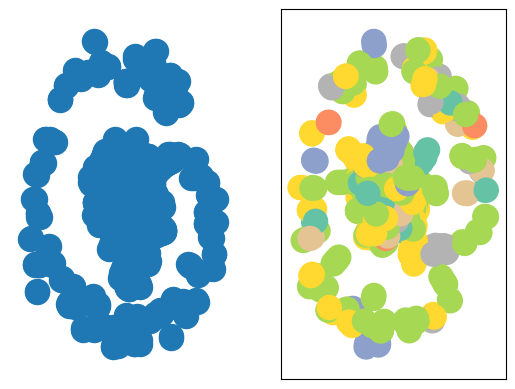

In [8]:
## Visualize the GNN networks ===================================================================
## Import packages required for visualization
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE

%matplotlib inline

def visualize_graph1(G, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])

    G.add_nodes_from(range(1, data.x.shape[0]))
    G.add_edges_from(data.edge_index.T.tolist())

    plt.sca(ax)
    # nx.draw(G, with_labels=True, font_weight='bold')
    nx.draw(G)

def visualize_graph2(G, color, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])

    plt.sca(ax)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")

# plt.cla()
# plt.clf()

## plt.subplot -> stated-based
## plt.subplots -> objected-oriented

## 1st method
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

## 2nd method
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

G = nx.Graph(name='G')
visualize_graph1(G, ax=ax1)

G = to_networkx(data, to_undirected=True)
visualize_graph2(G, color=data.y, ax=ax2)

plt.show()

In [9]:
## Evaluate the model, then add training data to the "untrained" model
## to visualize various nodes and categories
def visualize(h, color):
    ## TSNE (T-distributed Stochastic Neighbor Embedding) is a tool to visualize high-dimensional data.
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

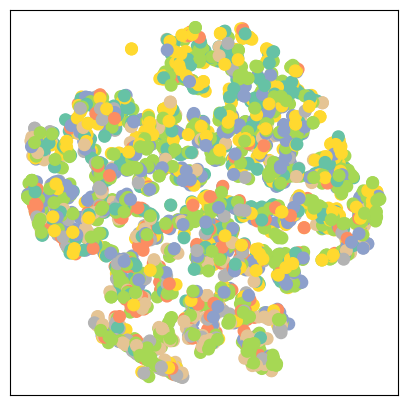

In [10]:
model1.eval()
out = model1(data.x, data.edge_index)

visualize(out, color=data.y)

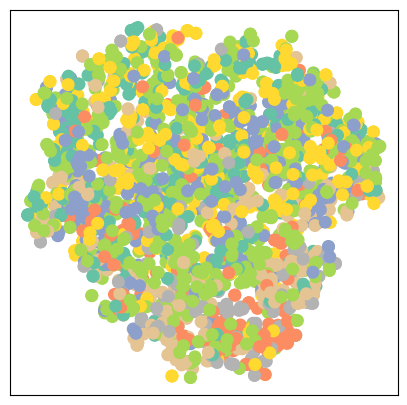

In [11]:
model2.eval()
out = model2(data.x, data.edge_index)

visualize(out, color=data.y)

In [12]:
# Train and test the GNN models ==================================================================
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)        # Initialize the Adam optimizer
def train1():
    model1.train()
    optimizer.zero_grad()       # Clear gradients
    out = model1(F.log_softmax(data.x, dim=1), data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()     # Derive gradients
    optimizer.step()     # Update parameters based on gradients

    return loss

def test1():
    model1.eval()
    pred = model1(data.x, data.edge_index).argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())

    return acc

In [13]:
for epoch in range(1, 101):
    loss = train1()
    if epoch % 10 == 0:
        print(f'Epoch : {epoch:03d}, | Train loss : {loss:.4f}')

print('\n')
acc = test1()
print(f'Test Accuracy: {acc:.4f}')

Epoch : 010, | Train loss : -341.2331
Epoch : 020, | Train loss : -2831.6550
Epoch : 030, | Train loss : -11519.8564
Epoch : 040, | Train loss : -33464.2773
Epoch : 050, | Train loss : -78923.1797
Epoch : 060, | Train loss : -161245.5156
Epoch : 070, | Train loss : -298060.4375
Epoch : 080, | Train loss : -510083.2500
Epoch : 090, | Train loss : -819490.5625
Epoch : 100, | Train loss : -1249490.6250


Test Accuracy: 0.3190


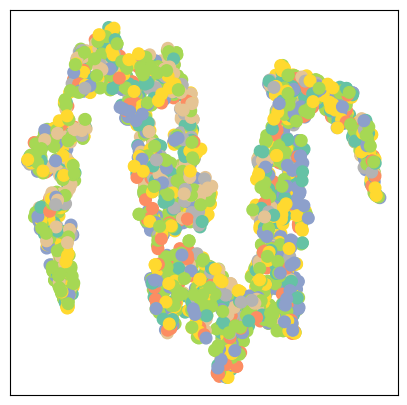

In [14]:
## Evaluate the model, then add training data to the "trained" model
## to visualize various nodes and categories
model1.eval()
out = model1(data.x, data.edge_index)
visualize(out, color=data.y)

In [15]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)        # Initialize the Adam optimizer
criterion = torch.nn.CrossEntropyLoss()        # Initialize the CrossEntropyLoss function
def train2():
    model2.train()
    optimizer.zero_grad()       # Clear gradients
    out = model2(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])     # Compute the loss solely based on the training nodes
    loss.backward()     # Derive gradients
    optimizer.step()     # Update parameters based on gradients

    return loss

def test2():
    model2.eval()
    pred = model2(data.x, data.edge_index).argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())

    return acc

In [16]:
for epoch in range(1, 101):
    loss = train2()
    if epoch % 10 == 0:
        print(f'Epoch : {epoch:03d}, | Train loss : {loss:.4f}')

print('\n')
acc = test2()
print(f'Test Accuracy : {acc:.4f}\n')

Epoch : 010, | Train loss : 0.8737
Epoch : 020, | Train loss : 0.2742
Epoch : 030, | Train loss : 0.1365
Epoch : 040, | Train loss : 0.0669
Epoch : 050, | Train loss : 0.0508
Epoch : 060, | Train loss : 0.0469
Epoch : 070, | Train loss : 0.0366
Epoch : 080, | Train loss : 0.0398
Epoch : 090, | Train loss : 0.0440
Epoch : 100, | Train loss : 0.0762


Test Accuracy : 0.7980



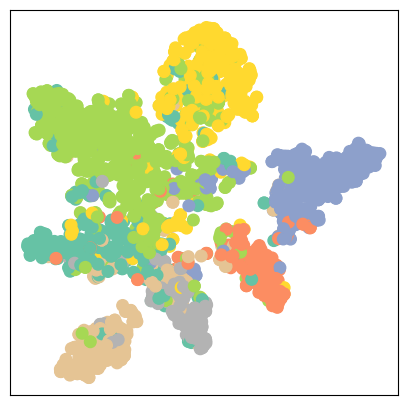

In [17]:
## Evaluate the model, then add training data to the "trained" model
## to visualize various nodes and categories
model2.eval()
out = model2(data.x, data.edge_index)
visualize(out, color=data.y)